In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import glob, os

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, activations, optimizers, losses, metrics, initializers
from tensorflow.keras.preprocessing import image, image_dataset_from_directory
from tensorflow.keras.applications import MobileNetV3Small, MobileNet, InceptionV3
from tensorflow.keras.applications.mobilenet_v3 import preprocess_input, decode_predictions

seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)

In [2]:
!pip install opendatasets --upgrade
import opendatasets as od

dataset_url = 'https://www.kaggle.com/datasets/aryashah2k/breast-ultrasound-images-dataset'
od.download(dataset_url)

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: pinky1234
Your Kaggle Key: ··········


100%|██████████| 195M/195M [00:01<00:00, 166MB/s]


In [3]:
data_dir = '/content/breast-ultrasound-images-dataset/Dataset_BUSI_with_GT/'

In [4]:
def prepare_image(file):
    img = image.load_img(file, target_size=(128,128))
    img_array = image.img_to_array(img)
    return tf.keras.applications.efficientnet.preprocess_input (img_array)

In [5]:
directories = os.listdir(data_dir) # read the folders

files = [] # save all images for each folder
labels = [] # set for each image the name of it

# read files for each directory
for folder in directories:
    
    fileList = glob.glob(data_dir + '/'+ folder + '/*')
    labels.extend([folder for l in fileList])
    files.extend(fileList)
    
len(files), len(labels)

(1578, 1578)

In [6]:
selected_files = []
selected_labels = []

for file, label in zip(files, labels):
    if 'mask'not in file:
        selected_files.append(file)
        selected_labels.append(label)

    
len(selected_files), len(selected_labels)

(780, 780)

In [7]:
images = {
    'image': [], 
    'target': []
}

print('Preparing the image...')

for i, (file, label) in enumerate(zip(selected_files, selected_labels)):
    images['image'].append(prepare_image(file))
    images['target'].append(label)

Preparing the image...


In [8]:
images['image'] = np.array(images['image'])
images['target'] = np.array(images['target'])

# encode the target
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

images['target'] = le.fit_transform(images['target'])

classes = le.classes_ # get the classes for each target
print(f'the target classes are: {classes}')

the target classes are: ['benign' 'malignant' 'normal']


In [9]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(images['image'], images['target'], test_size=.10)

x_train.shape, x_test.shape, y_train.shape, y_test.shape 

((702, 128, 128, 3), (78, 128, 128, 3), (702,), (78,))

In [10]:
from tensorflow.keras.applications import EfficientNetB7
base_model = EfficientNetB7(
    include_top=False,
    weights='imagenet',
    input_shape=(128,128, 3),
    classes=3)

# Freeze the base_model
base_model.trainable = False

# append my own layers on the top of the model for Transfer Learning
x = base_model.output

# 1st conv block
x = layers.Conv2D(256, 3, padding='same')(x)
x = layers.BatchNormalization()(x)
x = layers.Activation('relu')(x)
x = layers.GlobalAveragePooling2D(keepdims = True)(x)

# 2nd conv block
x = layers.Conv2D(128, 3, padding='same')(x)
x = layers.BatchNormalization()(x)
x = layers.Activation('relu')(x)
x = layers.GlobalAveragePooling2D(keepdims = True)(x)

# 1st FC layer
x = layers.Flatten()(x) 
x = layers.Dense(64)(x)
x = layers.BatchNormalization()(x)
x = layers.Activation('relu')(x)

# 2nd FC layer
x = layers.Dense(32, activation = 'relu')(x)
x = layers.BatchNormalization()(x)
x = layers.Activation('relu')(x)
x = layers.Dropout(.2)(x)

x = layers.Dense(3, 'softmax')(x)

incept_model = keras.models.Model(inputs = base_model.input, outputs = x)

# compile the model
incept_model.compile(optimizer=optimizers.RMSprop(.001), loss = losses.sparse_categorical_crossentropy, metrics= [metrics.SparseCategoricalAccuracy()])

258088960/258076736 [==============================] - 5s 0us/step


In [37]:
earlyStop = keras.callbacks.EarlyStopping(patience=60) 
best_model = keras.callbacks.ModelCheckpoint(filepath='best_model.h5', save_best_only=True) 

with tf.device('/gpu:0'):
    history = incept_model.fit(x_train, y_train, batch_size=32, epochs=200, validation_data=(x_test, y_test), callbacks=[earlyStop, best_model])

Epoch 1/200
22/22 [==============================] - 11s 488ms/step - loss: 0.1037 - sparse_categorical_accuracy: 0.9701 - val_loss: 0.8320 - val_sparse_categorical_accuracy: 0.8077
Epoch 2/200
22/22 [==============================] - 8s 374ms/step - loss: 0.0555 - sparse_categorical_accuracy: 0.9815 - val_loss: 1.5993 - val_sparse_categorical_accuracy: 0.7692
Epoch 3/200
22/22 [==============================] - 8s 373ms/step - loss: 0.0485 - sparse_categorical_accuracy: 0.9815 - val_loss: 0.9919 - val_sparse_categorical_accuracy: 0.8590
Epoch 4/200
22/22 [==============================] - 8s 375ms/step - loss: 0.0578 - sparse_categorical_accuracy: 0.9758 - val_loss: 1.4299 - val_sparse_categorical_accuracy: 0.8205
Epoch 5/200
22/22 [==============================] - 10s 483ms/step - loss: 0.0528 - sparse_categorical_accuracy: 0.9815 - val_loss: 0.8022 - val_sparse_categorical_accuracy: 0.8846
Epoch 6/200
22/22 [==============================] - 11s 507ms/step - loss: 0.0590 - sparse_c

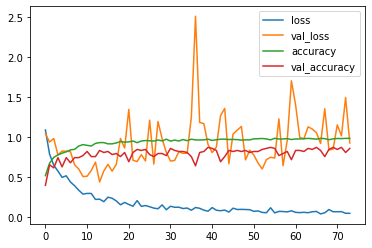

In [12]:
hist = history.history

plt.plot(hist['loss'], label=  'loss')
plt.plot(hist['val_loss'], label = 'val_loss')
plt.plot(hist['sparse_categorical_accuracy'], label='accuracy')
plt.plot(hist['val_sparse_categorical_accuracy'], label='val_accuracy')
plt.legend()

In [13]:
def predict_image(img_path, label):
    img1 = prepare_image(img_path) # preprocess the image
    res = incept_model.predict(np.expand_dims(img1, axis = 0)) # predict the image
    pred = classes[np.argmax(res)]

    # Visualize the image
    img = image.load_img(img_path)
    plt.imshow(np.array(img))
    plt.title(f'True: {label}\nPredicted: {pred}')

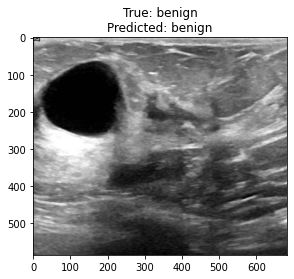

In [38]:
predict_image(data_dir + 'benign/benign (10).png', 'benign')

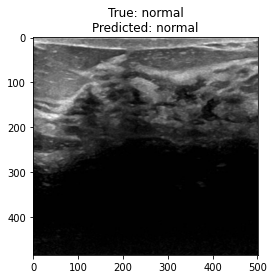

In [39]:
predict_image(data_dir + 'normal/normal (10).png', 'normal')

# VGG 16

In [16]:
from keras.applications.vgg16 import VGG16, preprocess_input
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.layers import Dense, Dropout, Flatten
from pathlib import Path

In [17]:
def create_model(input_shape, n_classes, optimizer='rmsprop', fine_tune=0):
  conv_base = VGG16(include_top=False,
                     weights='imagenet', 
                     input_shape=input_shape)
  if fine_tune > 0:
        for layer in conv_base.layers[:-fine_tune]:
            layer.trainable = False
  else:
    for layer in conv_base.layers:
      layer.trainable = False
  top_model = conv_base.output
  top_model = Flatten(name="flatten")(top_model)
  top_model = Dense(4096, activation='relu')(top_model)
  top_model = Dense(1072, activation='relu')(top_model)
  top_model = Dropout(0.2)(top_model)
  output_layer = Dense(n_classes, activation='softmax')(top_model)
  model = Model(inputs=conv_base.input, outputs=output_layer)
  model.compile(optimizer=optimizer, 
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
  return model

In [18]:
BATCH_SIZE = 64

In [19]:
from keras.losses import categorical_crossentropy
#from keras.layers import Activation, BatchNormalization, Conv2D, Dense, Flatten, MaxPooling2D
from keras.layers import Activation, BatchNormalization, Dense, Dropout, Flatten, GlobalAveragePooling2D
from tensorflow.keras.applications import densenet, inception_v3, mobilenet, resnet50, vgg16, vgg19, xception
from keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam
from keras import regularizers
from tensorflow.keras.utils import to_categorical as keras_to_categorical

In [20]:
input_shape = (128,128, 3)
optim_1 = optimizers.RMSprop(.001)
n_classes=3
optim_2 = Adam(learning_rate=0.001)
n_epochs = 50
vgg_model = create_model(input_shape, n_classes, optim_1, fine_tune=0)
vgg_model1 = create_model(input_shape, n_classes, optim_2, fine_tune=0)

58900480/58889256 [==============================] - 1s 0us/step


In [21]:
best_model1 = ModelCheckpoint(filepath='vgg_bc.h5',
                                  save_best_only=True,
                                  verbose=1)

# EarlyStopping
early_stop = EarlyStopping(monitor='val_loss',
                           patience=10,
                           restore_best_weights=True,
                           mode='min')

In [22]:
best_model2 = ModelCheckpoint(filepath='vgg_bcA.h5',
                                  save_best_only=True,
                                  verbose=1)


In [23]:
with tf.device('/gpu:0'):
    history1 = vgg_model.fit(x_train, y_train, batch_size=64, epochs=200, validation_data=(x_test, y_test), callbacks=[early_stop,best_model1])

Epoch 1/200
11/11 [==============================] - ETA: 0s - loss: 163.1676 - accuracy: 0.4658
Epoch 1: val_loss improved from inf to 8.41270, saving model to vgg_bc.h5
11/11 [==============================] - 12s 818ms/step - loss: 163.1676 - accuracy: 0.4658 - val_loss: 8.4127 - val_accuracy: 0.6154
Epoch 2/200
11/11 [==============================] - ETA: 0s - loss: 2.9849 - accuracy: 0.6724
Epoch 2: val_loss improved from 8.41270 to 2.24338, saving model to vgg_bc.h5
11/11 [==============================] - 4s 366ms/step - loss: 2.9849 - accuracy: 0.6724 - val_loss: 2.2434 - val_accuracy: 0.6667
Epoch 3/200
11/11 [==============================] - ETA: 0s - loss: 0.7550 - accuracy: 0.8291
Epoch 3: val_loss improved from 2.24338 to 0.89318, saving model to vgg_bc.h5
11/11 [==============================] - 4s 360ms/step - loss: 0.7550 - accuracy: 0.8291 - val_loss: 0.8932 - val_accuracy: 0.8205
Epoch 4/200
11/11 [==============================] - ETA: 0s - loss: 0.2803 - accuracy:

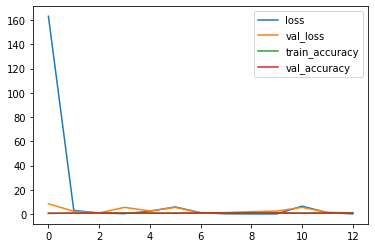

In [24]:
hist1 = history1.history

plt.plot(hist1['loss'], label=  'loss')
plt.plot(hist1['val_loss'], label = 'val_loss')
plt.plot(hist1['accuracy'], label='train_accuracy')
plt.plot(hist1['val_accuracy'], label='val_accuracy')
plt.legend()

In [25]:
def predict_image1(img_path, label):
    img1 = prepare_image(img_path) # preprocess the image
    res = vgg_model.predict(np.expand_dims(img1, axis = 0)) # predict the image
    pred = classes[np.argmax(res)]

    # Visualize the image
    img = image.load_img(img_path)
    plt.imshow(np.array(img))
    plt.title(f'True: {label}\nPredicted: {pred}')

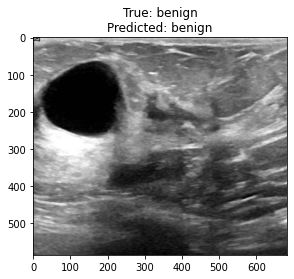

In [40]:
predict_image1(data_dir + 'benign/benign (10).png', 'benign')

In [27]:
with tf.device('/gpu:0'):
    history2 = vgg_model1.fit(x_train, y_train, batch_size=32, epochs=200, validation_data=(x_test, y_test), callbacks=[early_stop,best_model2])

Epoch 1/200
22/22 [==============================] - ETA: 0s - loss: 47.3287 - accuracy: 0.4729
Epoch 1: val_loss improved from inf to 0.86544, saving model to vgg_bcA.h5
22/22 [==============================] - 9s 308ms/step - loss: 47.3287 - accuracy: 0.4729 - val_loss: 0.8654 - val_accuracy: 0.6667
Epoch 2/200
22/22 [==============================] - ETA: 0s - loss: 0.7335 - accuracy: 0.7222
Epoch 2: val_loss improved from 0.86544 to 0.70173, saving model to vgg_bcA.h5
22/22 [==============================] - 5s 211ms/step - loss: 0.7335 - accuracy: 0.7222 - val_loss: 0.7017 - val_accuracy: 0.7821
Epoch 3/200
22/22 [==============================] - ETA: 0s - loss: 0.2450 - accuracy: 0.9103
Epoch 3: val_loss improved from 0.70173 to 0.62249, saving model to vgg_bcA.h5
22/22 [==============================] - 4s 202ms/step - loss: 0.2450 - accuracy: 0.9103 - val_loss: 0.6225 - val_accuracy: 0.8205
Epoch 4/200
22/22 [==============================] - ETA: 0s - loss: 0.1140 - accuracy:

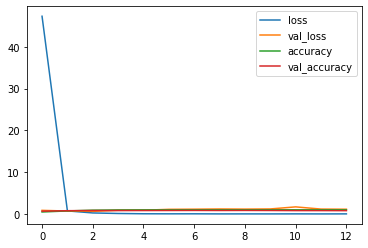

In [28]:
hist2 = history2.history

plt.plot(hist2['loss'], label=  'loss')
plt.plot(hist2['val_loss'], label = 'val_loss')
plt.plot(hist2['accuracy'], label='accuracy')
plt.plot(hist2['val_accuracy'], label='val_accuracy')
plt.legend()

# MobileNet

In [29]:
IMG_SHAPE = (128,128,3)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                              include_top=False,
                                              weights='imagenet')

9420800/9406464 [==============================] - 0s 0us/step


In [30]:
best_model3 = ModelCheckpoint(filepath='best_modelmo.h5',
                                  save_best_only=True,
                                  verbose=1)

In [31]:
base_model.trainable = False
model = tf.keras.Sequential([
                          base_model,
                          keras.layers.GlobalAveragePooling2D(),
                          keras.layers.Dense(3, activation='sigmoid')])

In [32]:
model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=0.01),
              loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/rmsprop.py:130: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


In [35]:
history3 = model.fit(x_train, y_train, batch_size=32, epochs=200, validation_data=(x_test, y_test), callbacks=[early_stop,best_model3])

Epoch 1/200
22/22 [==============================] - ETA: 0s - loss: 1.4773 - accuracy: 0.6282
Epoch 1: val_loss improved from inf to 1.15919, saving model to best_modelmo.h5
22/22 [==============================] - 2s 115ms/step - loss: 1.4773 - accuracy: 0.6282 - val_loss: 1.1592 - val_accuracy: 0.5897
Epoch 2/200
22/22 [==============================] - ETA: 0s - loss: 1.5056 - accuracy: 0.6453
Epoch 2: val_loss did not improve from 1.15919
22/22 [==============================] - 1s 47ms/step - loss: 1.5056 - accuracy: 0.6453 - val_loss: 1.5804 - val_accuracy: 0.6410
Epoch 3/200
22/22 [==============================] - ETA: 0s - loss: 1.4407 - accuracy: 0.6339
Epoch 3: val_loss did not improve from 1.15919
22/22 [==============================] - 1s 48ms/step - loss: 1.4407 - accuracy: 0.6339 - val_loss: 2.3316 - val_accuracy: 0.6026
Epoch 4/200
21/22 [===========================>..] - ETA: 0s - loss: 1.2232 - accuracy: 0.6562
Epoch 4: val_loss improved from 1.15919 to 0.99204, sav

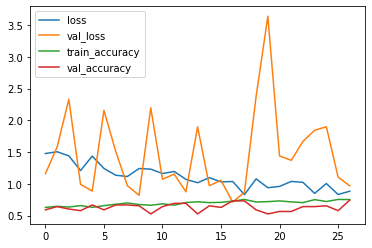

In [36]:
hist3 = history3.history

plt.plot(hist3['loss'], label=  'loss')
plt.plot(hist3['val_loss'], label = 'val_loss')
plt.plot(hist3['accuracy'], label='train_accuracy')
plt.plot(hist3['val_accuracy'], label='val_accuracy')
plt.legend()